self.datetime_date = 2025-06-12 08:00:00+00:00
type: <class 'datetime.datetime'>
0


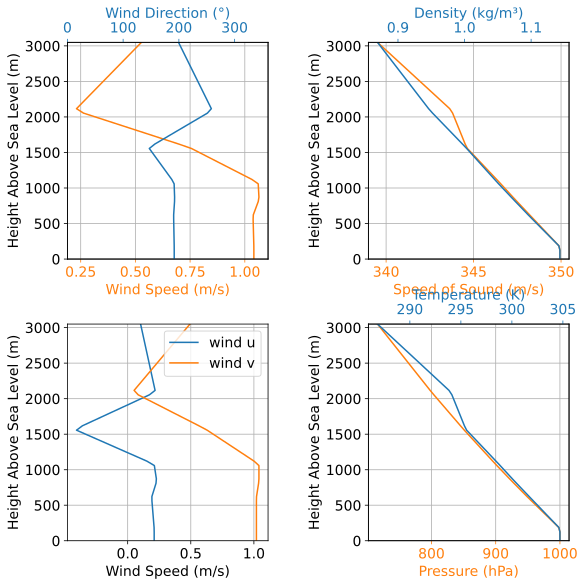

TOTAL SIMS IS: 1
self.datetime_date = 2025-06-12 08:00:00+00:00
type: <class 'datetime.datetime'>
0


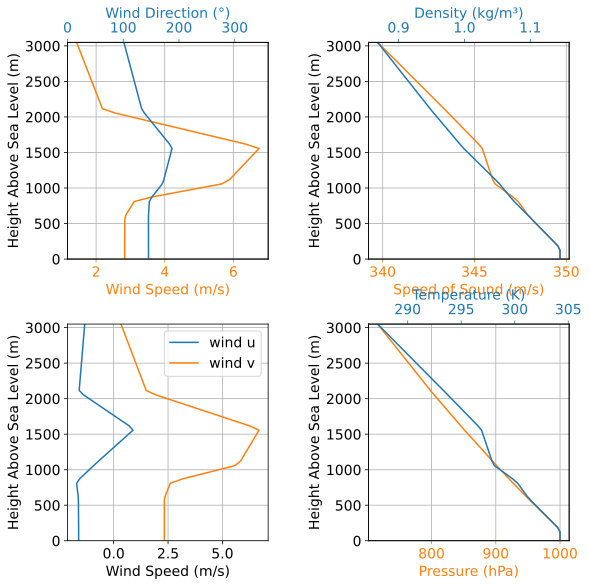

CURRENT HOUR IS 8, CURRENT DAY IS: 12


'Starting'

In [ ]:
from datetime import datetime
from time import process_time, time
import pandas as pd
from rocketpy import Environment, SolidMotor, Rocket, Flight
import concurrent.futures
from ConcurrentFunctions import runFlightWithMonteCarlo
from rocketpy.motors import motor
from IPython.display import display
from scipy.stats import norm
from rocketpy.mathutils.function import Function
from rocketpy.environment import environment

#Calculate and plot landing elipses
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

import FlightParams

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

from wind import makeWind

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14


import logging
import numpy as np

launchDate = [2025, 6, 12, 8]

# Iterate the loop to read the cell values
env = Environment(
    date=launchDate,
    latitude=FlightParams.envParams["latitude"],
    longitude=FlightParams.envParams["longitude"],
    max_expected_height=3050
)

env.set_atmospheric_model(type=FlightParams.envParams["type"], file=FlightParams.envParams["file"])
env.plots.atmospheric_model()

#env = Environment(latitude = FlightParams.envParams["latitude"], longitude = FlightParams.envParams["longitude"], elevation = FlightParams.envParams["elevation"])

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (FlightParams.spMass, 0), #.001
    # # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    # "rocket_inertia_11": (FlightParams.spCentralDiameter, 0.036),
    # # Rocket's inertia moment relative to its axis (kg*m^2)
    # "rocket_inertia_33": (FlightParams.spCentralAxis, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (FlightParams.dryMotorMass, 0), #.001
    # # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    # "motor_inertia_11": (FlightParams.motor_11_inertia, 0.016),
    # # Motors's dry inertia moment relative to its axis (kg*m^2)
    # "motor_inertia_33": (FlightParams.motor_33_inertia, 0.00001),\
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)
    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (np.abs(FlightParams.the_motor_center_of_dry_mass_position - FlightParams.rocket_center_of_dry_mass_position), 0), #.001
    # Motor total impulse (N*s)
    "impulse": (FlightParams.impulse, 0), #25.3

    # "motor_position": (FlightParams.the_motor_position, .01),

    # Motor burn out time (s)
    # "burn_time": (FlightParams.burn_time, .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (FlightParams.the_nozzle_radius, 0), #.5 / 1000
    # Motor's nozzle throat radius (m)
    "throat_radius": (FlightParams.the_throat_radius, 0), #.5 / 1000
    # Motor's grain separation (axial distance between two grains) (m)
    # "grain_separation": (FlightParams.grainSeparation, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (FlightParams.motor_density, 0), #20
    # Motor's grain outer radius (m)
    # "grain_outer_radius": (FlightParams.grainOuterRadius, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (FlightParams.grainInnerRadius, 0), #.3 / 1000
    # Motor's grain height (m)
    "grain_initial_height": (FlightParams.grainHeight, 0), #1 / 1000
    # Rocket's radius (kg*m^2)
    # "radius": (FlightParams.spRadius, 0.001),
    # Nozle position relative to motor
    # "nozzle_position": (FlightParams.the_nozzle_position, 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (FlightParams.rocket_center_of_dry_mass_position-(FlightParams.the_motor_center_of_dry_mass_position + FlightParams.the_motor_position), 0), #.0001
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    # "nose_distance_to_CM": (FlightParams.rocket_center_of_dry_mass_position-FlightParams.nose_cone_length, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (FlightParams.inclination, 0), #1
    # Launch rail heading relative to north (degrees)
    "heading": (FlightParams.heading, 0), #2
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (FlightParams.drogueCdS, 0), #.02
    # Drag coefficient times reference area for the light chute
    "cd_s_light": (FlightParams.lightCdS, 0), #.02
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (FlightParams.lag_rec, 0), #.2
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (FlightParams.lag_se, 0), #.1
    # temperature in kelvin
    "temperature": (FlightParams.kelvin_temp, 0), #5
    # atmospheric pressure in pascals
    "atmosphere_pressure": (env.pressure_ISA(FlightParams.envParams["elevation"]), 0), #300

    #without motor
    "rocket_CM": (FlightParams.rocket_center_of_dry_mass_position, 0), #.01

    # adding these, but they don't vary
    "time_to_deploy_airbrake_after_burnout": (-1, 0),
    "fin_position": (2.62, 0)
}

# M1850W.all_info()

#sets up the ability to log inputs.
def setup_logging():
    class MyHandler(logging.FileHandler):
        def emit(self, record):
            super().emit(record)  # Call the superclass's emit method
            self.flush()  # Flush after each log message

    # Use your custom handler
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = MyHandler('app.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

resultsFile = open(FlightParams.generatedFilesLocation + "results.txt", "w")

def createDistributionPlot(dispersonResultArray, name, lowerProbBound, upperProbBound, maxDecimals, percentConfidence, hypothesis, unit, makeGraph, filename):
    mean = np.mean(dispersonResultArray)
    deviation = np.std(dispersonResultArray)
    unitString = ""
    if(unit == "meters"):
        unitString = "m"
    print(
        f'{name} -         Mean Value: {mean:0.3f} ' + unitString
    )
    resultsFile.write(f'{name} -         Mean Value: {mean:0.3f} ' + unitString + "\n")
    print(
        f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString
    )
    resultsFile.write(f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString + "\n")
    if(makeGraph):

        minimum = np.min(dispersonResultArray)
        maximum = np.max(dispersonResultArray)
        theBins = list()

        #using scott's rule to find the number of bins
        binWidth = 3.5 * deviation / np.power(len(dispersonResultArray), 1/3)
        numBins = int(np.round((maximum-minimum)/binWidth))

        changeInZ = (maximum - minimum) / numBins
        #test add
        zIterator = minimum
        for iterator in range(numBins):
            theBins.append(zIterator)
            zIterator += changeInZ
        finalValue = np.ceil(zIterator * np.power(10, maxDecimals)) / np.power(10, maxDecimals)
        theBins.append(finalValue)
        plt.figure()
        plt.xlim(minimum, maximum)
        minTextSize = 8
        maxTickCount = 50
        xTickBins = theBins
        if(numBins > maxTickCount):
            xTickBins = list()
            changeInZ = (maximum - minimum) / 50.0
            zIterator = minimum
            for iterator in range(50):
                xTickBins.append(zIterator)
                zIterator += changeInZ
        binListToString = list()
        for currentBin in xTickBins:
            binListToString.append(str(round(currentBin, maxDecimals)))
        plt.xticks(ticks = xTickBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
        plt.hist(dispersonResultArray, bins=theBins)
        plt.title(name)
        plt.xlabel(name)
        plt.ylabel("Number of Occurences")

        plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
        plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.savefig(FlightParams.generatedFilesLocation + str(filename) + "Graph.png", bbox_inches="tight", pad_inches=0)
        plt.show()
    lowerZ = (lowerProbBound - mean)/deviation
    upperZ = (upperProbBound - mean)/deviation
    probabilityInRange = norm.cdf(upperZ) - norm.cdf(lowerZ)
    print("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%")
    resultsFile.write("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%\n")
    if(percentConfidence != 100):
        aVal = (100 - percentConfidence)/100
        newZ = np.abs(norm.ppf(aVal/2))
        lowerBoundOfInterval = mean - newZ * deviation/np.sqrt(len(dispersonResultArray))
        upperBoundOfInterval = mean + newZ * deviation/np.sqrt(len(dispersonResultArray))
        print("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval))
        resultsFile.write("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval) + "\n")
        if(hypothesis != None):
            criticalValue = norm.ppf(aVal / 2)
            testStatistic = (mean - hypothesis) * np.sqrt(len(dispersonResultArray))/deviation
            print("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic))
            resultsFile.write("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic) + "\n")
            if(testStatistic < criticalValue):
                print("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
                resultsFile.write("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n\n")
            else:
                print("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
                resultsFile.write("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n\n")

# envParams["file"] = row[0].value

print("TOTAL SIMS IS: " + str(FlightParams.numberSims))
resultsFile.write("TOTAL SIMS IS: " + str(FlightParams.numberSims) + "\n\n\n")


for day in [12]:
    # varyingParamVals = [9,]
    # apogeeAtIteration = [0,]
    varyingParamVals = []
    apogeeAtIteration = []
    currentVal = -1
    endVal = -1
    incrementAmount = -1
    if(FlightParams.varyingVariable == "airbrake"):   
        currentVal = 1
        endVal = 21
        incrementAmount = 1
    elif (FlightParams.varyingVariable == "finposition"):
        currentVal = 2.55
        endVal = 2.62
        incrementAmount = 0.005
    elif (FlightParams.varyingVariable == "weatherHour"):
        currentVal = launchDate[3]
        endVal = 18
        incrementAmount = 1
    
    #range only accepts integer values, so for now we make them integers and divide them later
    while(True):
        theLaunchDate = [launchDate[0], launchDate[1], launchDate[2], currentVal]
        
        if(FlightParams.varyingVariable == "airbrake"):
            print("THIS IS WHERE WE DEPLOY AIRBRAKE " + str(currentVal) + " SECONDS AFTER BURNOUT")
            resultsFile.write("THIS IS WHERE WE DEPLOY AIRBRAKE " + str(currentVal) + " SECONDS AFTER BURNOUT\n")
            analysis_parameters["time_to_deploy_airbrake_after_burnout"] = (currentVal, 0)
            varyingParamVals.append(currentVal)
        elif(FlightParams.varyingVariable == "finposition"):
            print("CURRENT FIN POSITION IS " + str(currentVal))
            resultsFile.write("CURRENT FIN POSITION IS " + str(currentVal) + "\n")
            analysis_parameters["fin_position"] = (currentVal, 0)
            varyingParamVals.append(currentVal)
        elif(FlightParams.varyingVariable == "weatherHour"):
            env = Environment(
                date=theLaunchDate,
                latitude=FlightParams.envParams["latitude"],
                longitude=FlightParams.envParams["longitude"],
                max_expected_height=3050
            )
            env.set_atmospheric_model(type=FlightParams.envParams["type"], file=FlightParams.envParams["file"])
            env.plots.atmospheric_model()
            print("CURRENT HOUR IS " + str(currentVal) + ", CURRENT DAY IS: " + str(day))
            resultsFile.write("CURRENT HOUR IS " + str(currentVal) + ", CURRENT DAY IS: " + str(day) + "\n")
            varyingParamVals.append(currentVal)

        setup_logging()
        # env.all_info()
        # Create data files for inputs, outputs and error logging
        filename = "MonteCarlo" + str(currentVal)
        MonteCarloErrorFile = open("CreatedFiles/" + str(filename) + ".Errors.txt", "w")
        MonteCarloInputFile = open("CreatedFiles/" + str(filename) + ".Input.txt", "w")
        MonteCarloOutputFile = open("CreatedFiles/" + str(filename) + ".Output.txt", "w")

        initial_wall_time = time()
        initial_cpu_time = process_time()
        # Iterate over flight settings
        out = display("Starting", display_id=True)
        number_of_simulations = FlightParams.numberSims
        totalProcesses = FlightParams.processes
        simsPerProcess = number_of_simulations / totalProcesses

        # runFlightWithMonteCarlo(simsPerProcess, FlightParams.envParams, analysis_parameters, initial_cpu_time, False, theLaunchDate)
        
        # start multiprocessing
        if __name__ == "__main__":
            with concurrent.futures.ProcessPoolExecutor(max_workers=totalProcesses) as executor:
                results = [executor.submit(runFlightWithMonteCarlo, simsPerProcess, FlightParams.envParams, analysis_parameters, initial_cpu_time, False, theLaunchDate) for _ in range(totalProcesses)] 
                for result in concurrent.futures.as_completed(results):
                    MonteCarloInputFile.write(result.result()[0] + "\n")
                    MonteCarloOutputFile.write(result.result()[1] + "\n")
                    MonteCarloErrorFile.write(result.result()[2] + "\n")

        ## Print and save total time
        final_string = f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
        resultsFile.write(f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s\n")
        out.update(final_string)
        MonteCarloInputFile.write(final_string + "\n")
        MonteCarloOutputFile.write(final_string + "\n")
        MonteCarloErrorFile.write(final_string + "\n")

        ## Close files
        MonteCarloInputFile.close()
        MonteCarloOutputFile.close()
        MonteCarloErrorFile.close()

        # Initialize variable to store all results
        dispersion_general_results = []

        dispersion_results = {
            "out_of_rail_time": [],
            "out_of_rail_velocity": [],
            "apogee_time": [],
            "apogee_altitude": [],
            "apogee_x": [],
            "apogee_y": [],
            "impact_x": [],
            "impact_y": [],
            "initial_static_margin": [],
            "out_of_rail_static_margin": [],
            "out_of_rail_stability_margin": [],
            "max_velocity": [],
            "execution_time": [],
        }

        # Get all dispersion results
        # Get file
        dispersion_output_file = open("CreatedFiles/" + str(filename) + ".Output.txt", "r+")

        # Read each line of the file and convert to dict
        for line in dispersion_output_file:
            # Skip comments lines
            if line[0] != "{":
                continue
            # Eval results and store them
            flight_result = eval(line)
            dispersion_general_results.append(flight_result)
            for parameter_key, parameter_value in flight_result.items():
                dispersion_results[parameter_key].append(parameter_value)

        # Close data file
        dispersion_output_file.close()

        # Print number of flights simulated
        N = len(dispersion_general_results)
        print("Number of simulations: ", N)
        resultsFile.write("Number of simulations: " + str(N) + "\n")

        # Retrieve dispersion data por apogee and impact XY position
        apogee_x = np.array(dispersion_results["apogee_x"])
        apogee_y = np.array(dispersion_results["apogee_y"])

        createDistributionPlot(dispersion_results["out_of_rail_stability_margin"], "Out Of Rail Stability Margin", lowerProbBound = 1.5, upperProbBound = 4, maxDecimals = 4, percentConfidence = 90, hypothesis = None, unit = "none", makeGraph = False, filename = "Rail" + str(currentVal))
        print("\n\n")
        resultsFile.write("\n\n")
        createDistributionPlot(dispersion_results["apogee_altitude"], "Apogee Altitude", lowerProbBound = 9900 * 0.3048, upperProbBound = 10100 * 0.3048, maxDecimals = 0, percentConfidence = 90, hypothesis = 3048, unit = "meter", makeGraph = False, filename = "Apogee" + str(currentVal))
        print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        resultsFile.write("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        apogeeAtIteration.append(np.mean(dispersion_results["apogee_altitude"]))

        #img = imread("background.jpeg")

        # # Retrieve dispersion data por apogee and impact XY position
        # impact_x = np.array(dispersion_results["impact_x"])
        # impact_y = np.array(dispersion_results["impact_y"])

        # print(f"Simulated Landing Position x = {np.mean(dispersion_results['impact_x'])}, y = {np.mean(dispersion_results['impact_y'])}")
        # resultsFile.write(f"Simulated Landing Position x = {np.mean(dispersion_results['impact_x'])}, y = {np.mean(dispersion_results['impact_y'])}\n")
        # # Define function to calculate eigen values
        # def eigsorted(cov):
        #     vals, vecs = np.linalg.eigh(cov)
        #     order = vals.argsort()[::-1]
        #     return vals[order], vecs[:, order]


        # # Create plot figure
        # plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
        # ax = plt.subplot(111)

        # # Calculate error ellipses for impact
        # impactCov = np.cov(impact_x, impact_y)
        # impactVals, impactVecs = eigsorted(impactCov)
        # impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
        # impactW, impactH = 2 * np.sqrt(impactVals)

        # # Draw error ellipses for impact
        # impact_ellipses = []
        # for j in [1, 2, 3]:
        #     impactEll = Ellipse(
        #         xy=(np.mean(impact_x), np.mean(impact_y)),
        #         width=impactW * j,
        #         height=impactH * j,
        #         angle=impactTheta,
        #         color="black",
        #     )
        #     impactEll.set_facecolor((0, 0, 1, 0.2))
        #     impact_ellipses.append(impactEll)
        #     ax.add_artist(impactEll)

        # # Calculate error ellipses for apogee
        # apogeeCov = np.cov(apogee_x, apogee_y)
        # apogeeVals, apogeeVecs = eigsorted(apogeeCov)
        # apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
        # apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

        # # Draw error ellipses for apogee
        # for j in [1, 2, 3]:
        #     apogeeEll = Ellipse(
        #         xy=(np.mean(apogee_x), np.mean(apogee_y)),
        #         width=apogeeW * j,
        #         height=apogeeH * j,
        #         angle=apogeeTheta,
        #         color="black",
        #     )
        #     apogeeEll.set_facecolor((0, 1, 0, 0.2))
        #     ax.add_artist(apogeeEll)

        # # Draw launch point
        # plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
        # # Draw apogee points
        # plt.scatter(
        #     apogee_x, apogee_y, s=5, marker="^", color="green", label="Simulated Apogee"
        # )
        # # Draw impact points
        # plt.scatter(
        #     impact_x, impact_y, s=5, marker="v", color="blue", label="Simulated Landing Point"
        # )

        # plt.legend()

        # # Add title and labels to plot
        # ax.set_title(
        #     "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points"
        # )
        # ax.set_ylabel("North (m)")
        # ax.set_xlabel("East (m)")

        # # Add background image to plot
        # # You can translate the basemap by changing dx and dy (in meters)
        # dx = 0
        # dy = 0
        # #plt.imshow(img, zorder=0, extent=[-1000 - dx, 1000 - dx, -1000 - dy, 1000 - dy])

        # plt.axhline(0, color="black", linewidth=0.5)
        # plt.axvline(0, color="black", linewidth=0.5)
        # plt.xlim(-5000, 5000)
        # plt.ylim(-5000, 5000)

        # Save plot and show result
        # plt.savefig("CreatedFiles/" + str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
        # plt.savefig("CreatedFiles/" + str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
        # plt.show()
        print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        resultsFile.write("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")

        currentVal += incrementAmount
        currentVal = round(currentVal, 5 )
        if(currentVal > endVal):
            break

    plt.scatter(varyingParamVals, apogeeAtIteration)
    if(FlightParams.varyingVariable == "airbrake"):
        plt.title("Apogees at Different Deployment Times")
        plt.xlabel("Airbrake Deployment Time (Seconds after Burnout)")
        plt.ylabel("Apogee for that Time")
    elif(FlightParams.varyingVariable == "finposition"):
        plt.title("Apogees at Different Fin Positions")
        plt.xlabel("Fin Position")
        plt.ylabel("Apogee for that Position")
    elif(FlightParams.varyingVariable == "weatherHour"):
        plt.title(f"Apogees for Different Hours On Day {day}")
        plt.xlabel("Hour (Military Time)")
        plt.ylabel("Apogee at that hour")
        plt.axhline(3048, color='k', linestyle='solid', linewidth=4)
        plt.text(9.75, 3048, f'Desired Apogee', va='bottom', ha='left', color='red')
        
    #creating the trendline with the given x and y values
    trendline = np.polyfit(varyingParamVals, apogeeAtIteration, 1)
    trendline = np.poly1d(trendline)
    # obtaining the y values from the trendline
    y_vals = trendline(varyingParamVals)

    # R^2 calculation
    residuals = apogeeAtIteration - y_vals
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((apogeeAtIteration - np.mean(apogeeAtIteration))**2)
    r_squared = 1 - (ss_res / ss_tot)

    #plotting the trendline
    # plt.plot(varyingParamVals, y_vals, "r", label="Trendline (R² = " + str(round(r_squared, 3)) + ")")
    # plt.legend()

    plt.savefig(FlightParams.generatedFilesLocation + f"FinalSimTable{day}.png", bbox_inches="tight", pad_inches=0)
    plt.show()
resultsFile.close()